# The Paired *t*-test
To begin our journey into the world of models for repeated measurements, we will start with the simplest possible example: the paired $t$-test. Last semester, we saw how the humble $t$-test can be subsumed into the linear model framework through the use of *dummy variables*. This same approach can be used with paired data[^paired-foot] because the difference between the *independent* and *paired* $t$-test does not lie with the *mean function*. We spent a lot of time last semester discussing different mean functions and, you will be glad to know, this all follows-over into the world of repeated measurements. The difference lies with the *variance function*. Specifically, how we can alter the variance function to accommodate non-zero correlation between the repeats? As we will see in this part of the lesson, there are *two* equivalent ways of doing this with paired data. One of them *side-steps* the issues of dependence whereas the other does not. However, it is useful to understand how both of these work because it provides some crucial insight into modelling repeated measurements that we will generalise as our models get more complex.     

## Two-sample vs Paired *t*-tests
To begin with, it is useful to examine *how* the results differ between a *two-sample* and *paired* $t$-test. We can don this in `R` by comparing the results of the `t.test()` function with `paired=FALSE` and `paired=TRUE`. To do this, we use the `mice2` data set from the `datarium` package, that contains the weight of a sample of 10 mice both *before* and *after* some treatment. The experimental question concerns whether the treatment affects the weight of the mice. The data is shown below

In [1]:
library('datarium')
data('mice2')
print(mice2)

   id before after
1   1  187.2 429.5
2   2  194.2 404.4
3   3  231.7 405.6
4   4  200.5 397.2
5   5  201.7 377.9
6   6  235.0 445.8
7   7  208.7 408.4
8   8  172.4 337.0
9   9  184.6 414.3
10 10  189.6 380.3


We can compare the output from a *two-sample* $t$-test and a *paired* $t$-test by changing the `paired=` argument of `t.test()`, as shown below

In [2]:
print(t.test(mice2$before, mice2$after, var.equal=TRUE, paired=TRUE))  # paired t-test
print(t.test(mice2$before, mice2$after, var.equal=TRUE, paired=FALSE)) # two-sample t-test


	Paired t-test

data:  mice2$before and mice2$after
t = -25.546, df = 9, p-value = 1.039e-09
alternative hypothesis: true mean difference is not equal to 0
95 percent confidence interval:
 -217.1442 -181.8158
sample estimates:
mean difference 
        -199.48 


	Two Sample t-test

data:  mice2$before and mice2$after
t = -17.453, df = 18, p-value = 9.974e-13
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -223.4926 -175.4674
sample estimates:
mean of x mean of y 
   200.56    400.04 



The output is a bit different between the two methods, so let us spend a little time unpacking what *is* and what *is not* different here. To begin with, the clearest differences between the two methods concern the $t$-statistic itself, the degrees of freedom, the $p$-value and the confidence interval. This is summarised in the table below 

| Test       | *t*-statistic | DoF | *p*-value | 95% CI            | 
| ---------- | ------------- | --- | --------- | ----------------- |
| Paired     | -25.546       | 9   | 1.039e-09 | [-217.14 -181.82] |
| Two-sample | -17.453       | 18  | 9.974e-13 | [-223.49 -175.47] |

Although this may therefore seem like *everything* is different, there is actually one element that is *identical* here, though it is somewhat hidden. To see it, consider that the structure of a $t$-test is

$$
t = \frac{\mu_{1} - \mu_{2}}{\text{SE}\{\mu_{1} - \mu_{2}\}},
$$

meaning that we think of the $t$ as the ratio between the *mean difference* and the *standard error of the mean difference*. The $t$-statistic is different between the *two-sample* and the *paired* tests, but this does not necessarily mean that all elements of this ratio are also different. Indeed, if we look at the output above we can see that the *paired* test reports a mean difference of `-199.48` and the *two-sample* test reports the individual means as `200.56` and `400.04`. If we calculate the mean difference in the *two-sample* test we get 

In [3]:
print(200.56 - 400.04)

[1] -199.48


So, this is *identical* between the *paired* and *two-sample* tests. This should not be surprising, as we already established that repeated measurements do not affect the mean function. So, in either case, the groups means are the same, the mean difference is the same and the *numerator* of the $t$-statistic is the same. From this, we can conclude that the *difference* between the two methods concerns the *denominator* of the $t$-statistic. In other words, *the standard error of the difference changes under repeated measurements*.

Given that we know the numerator for both tests, we can recover the denominators to see that this is the case

In [4]:
mean.diff  <- -199.48
paired.t   <- -25.546
twosamp.t  <- -17.453
paired.se  <-  mean.diff / paired.t
twosamp.se <-  mean.diff / twosamp.t

print(c(paired.se, twosamp.se))

[1]  7.808659 11.429554


So, the *standard error* of the difference is much *smaller* in the *paired* test when compared to the *two-sample* test. This should not be a surprise. Thinking back to our discussion from the beginning of the lesson, we know that the variance of the difference between two random variables should get *smaller* when they are positively correlated. From this, we can conclude that, when applied to *paired* data, the *two-sample* $t$-test is using a standard error that is *too large*. 

This tracks with everything we have discussed so far. However, the key question for us is *how* the *paired* $t$-test is able to do this. As mentioned at the start of this part of the lesson, there are two equivalent ways of thinking about this. We will discuss *both* below because their equivalence provides important information for conceptualising more complex methods. 

## The Model of *Paired Differences*
The first method we can use is actually a bit of a *cheat* in order to side-step the issue of dependence. Effectively, a paired $t$-test can be thought of as a *one-sample* $t$-test on the *difference* between the pairs. We will explore this in more detail below, however, it is useful to know that conceptually this is a really key step because it introduces the idea that we can correctly model repeated measurements by *removing* something from the data. If we can make the paired test correct via subtraction, there must be something that is cancelling-out. Whatever this "something" is, its removal allows us to treat the *differences* between the pairs as independent.

### Paired Differences in `R`
As a first step, we can demonstrate that this idea of subtracting the pairs *does* work, before exploring *why*. We can use the `mice2` data again and create a new variable that represents the difference between `before` the treatment and `after` the treatment.

In [5]:
mice2$treat.diff <- mice2$before - mice2$after
print(mice2)

   id before after treat.diff
1   1  187.2 429.5     -242.3
2   2  194.2 404.4     -210.2
3   3  231.7 405.6     -173.9
4   4  200.5 397.2     -196.7
5   5  201.7 377.9     -176.2
6   6  235.0 445.8     -210.8
7   7  208.7 408.4     -199.7
8   8  172.4 337.0     -164.6
9   9  184.6 414.3     -229.7
10 10  189.6 380.3     -190.7


Now, we can simply perform a one-sample $t$-test on the difference. To do this, we could use the `t.test()` function, but given that our focus is linear models, we will use `lm()` instead.

In [6]:
onesamp.mod <- lm(treat.diff ~ 1, data=mice2)
summary(onesamp.mod)


Call:
lm(formula = treat.diff ~ 1, data = mice2)

Residuals:
   Min     1Q Median     3Q    Max 
-42.82 -11.17   1.28  19.66  34.88 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) -199.480      7.809  -25.55 1.04e-09 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 24.69 on 9 degrees of freedom


The test on the intercept parameter $(\beta_{0})$ is now *identical* to the paired $t$-test from earlier. We can also compare two different ways of using `t.test()`, one using a one-sample test of the differences and the other using the full paired test

In [7]:
print(t.test(mice2$treat.diff))
print(t.test(mice2$before, mice2$after, var.equal=TRUE, paired=TRUE))


	One Sample t-test

data:  mice2$treat.diff
t = -25.546, df = 9, p-value = 1.039e-09
alternative hypothesis: true mean is not equal to 0
95 percent confidence interval:
 -217.1442 -181.8158
sample estimates:
mean of x 
  -199.48 


	Paired t-test

data:  mice2$before and mice2$after
t = -25.546, df = 9, p-value = 1.039e-09
alternative hypothesis: true mean difference is not equal to 0
95 percent confidence interval:
 -217.1442 -181.8158
sample estimates:
mean difference 
        -199.48 



As we can see, these are identical. So, this provided some key insight that we will build on to understand *how* models of repeated measurements work.

### Removing the Effect of the Subjects
Given what we have demonstrated above, the key insight is that taking $D_{i} = y_{i1} - y_{i2}$ allows us to treat the values of $D_{i}$ as *independent*. Effectively, the element that makes repeated measurements difficult has been *removed* via this subtraction. Given that we know that *correlation* is the issue, taking $D_{i} = y_{i1} - y_{i2}$ *must* be removing the correlation from the data. This is fairly intuitive because we have reduced correlated pairs of data down to only a single value per-subject. Given that the subjects are taken as independent, the values of $D_{i}$ must also be independent. In effect, there are *no* repeated measurements anymore. However, expressing this formally is a useful stepping-stone to more general methods, particularly when we have more than two repeated measurements.

To see what is happening, let us *add* a shared component to the model of $y_{i1}$ and $y_{i2}$. We will call this $S_{i}$

$$
\begin{alignat*}{1}
    y_{i1} &= \mu_{1} + S_{i} + \epsilon_{i1} \\
    y_{i2} &= \mu_{2} + S_{i} + \epsilon_{i2} 
\end{alignat*}.
$$

So, the reason why $y_{i1}$ and $y_{i2}$ are correlated is because they *share* the same component $S_{i}$. This captures the idea that these measurements come from the same *subject*. If we then *subtract* $y_{i1}$ and $y_{i2}$, the term $S_{i}$ will cancel-out

$$
\begin{alignat*}{1}
    D_{i} = y_{i1} - y_{i2} &= (\mu_{1} - \mu_{2}) + (S_{i} - S_{i}) + (\epsilon_{i1} - \epsilon_{i2}) \\
                            &= (\mu_{1} - \mu_{2}) + (\epsilon_{i1} - \epsilon_{i2})
\end{alignat*}.
$$

So, this tells us that $S_{i}$ precisely captures the *correlation*, because removing it renders the data *independent*. 

We can also visualise what is happening, to gain further intuition. The plot below shows each mouse along the $x$-axis, with their weight along the $y$-axis. The two treatments are shown for each mouse as two different coloured points.

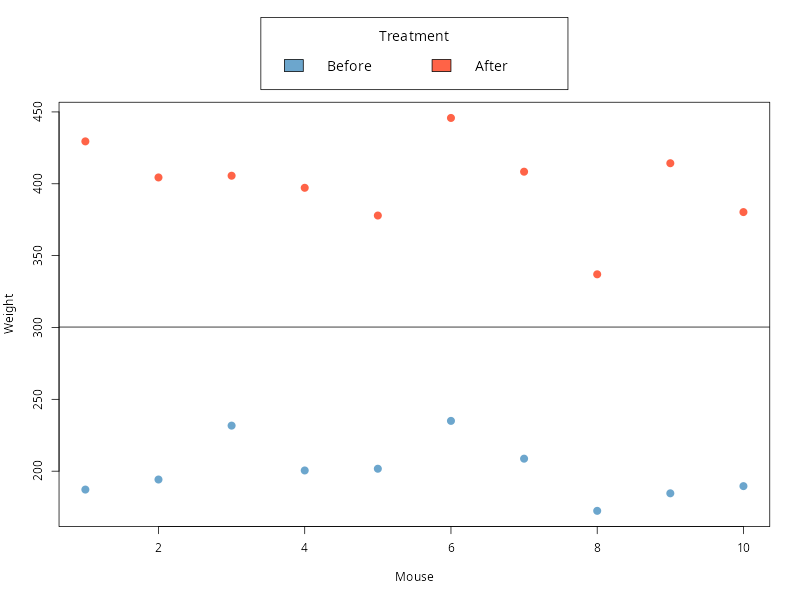

In [8]:
library(reshape2)
data('mice2')

mice2.long <- melt(mice2, 
                   id.vars       = "id", 
                   variable.name = "treatment", 
                   value.name    = "weight")
p <- par()
par(mar=c(5.1, 4.1, 7.1, 2.1), xpd=TRUE)

plot(mice2.long$id,
     mice2.long$weight,
     col=c(rep('skyblue3',10),rep('tomato1',10)),
     xlab='Mouse',
     ylab='Weight',
     pch=16,
     cex=1.5)

abline(h=mean(mice2.long$weight), xpd=FALSE)

legend("top", 
       inset=c(0,-.2), 
       title="Treatment",
       c("Before","After"), 
       fill=c('skyblue3','tomato1'), 
       horiz=TRUE, 
       cex=1.2)

According to the model

$$
y_{ij} = \mu_{j} + S_{i} + \epsilon_{ij}
$$

there are *three* sources of variance in these data. The first is variation associated with the two treatments (the $\mu_{j}$ terms), the second is variation associated with the different subjects (the $S_{i}$ terms) and the third is random error unrelated to anything else (the $\epsilon_{ij}$ terms). These are taken as three separate explanations for why the data shown above deviates from the *grand mean* (the solid horizontal line). 

In order to understand this in more detail, and how it relates to repeated measurements, we can *remove* each source of variance from the data and then see what the plot looks like. Starting with the two treatments, if we remove the mean of each treatment from each data point we get the following 

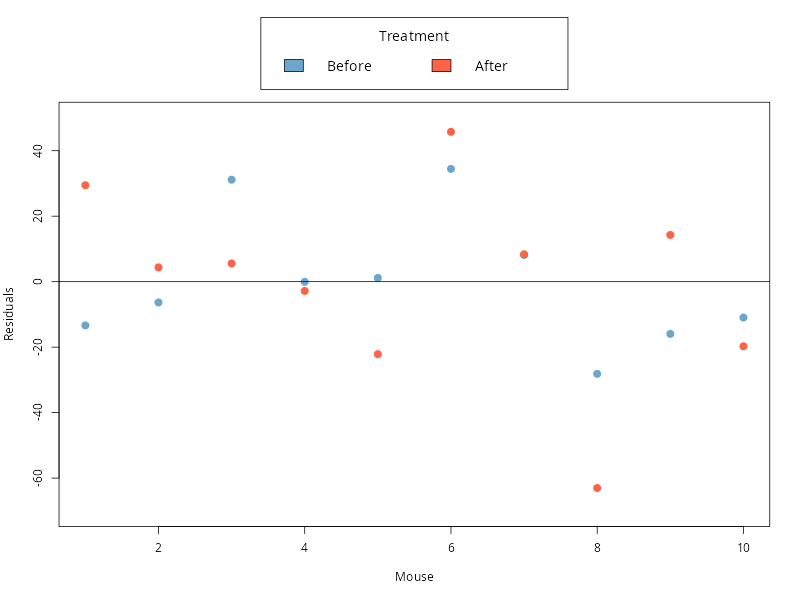

In [9]:
res.twosample <- resid(lm(weight ~ treatment, data=mice2.long))

par(mar=c(5.1, 4.1, 7.1, 2.1), xpd=TRUE)

plot(mice2.long$id,
     res.twosample,
     col=c(rep('skyblue3',10),rep('tomato1',10)),
     xlab='Mouse',
     ylab='Residuals',
     pch=16,
     cex=1.5,
     ylim=c(-70,50))

abline(h=0, xpd=FALSE)

legend("top", 
       inset=c(0,-.2), 
       title="Treatment",
       c("Before","After"), 
       fill=c('skyblue3','tomato1'), 
       horiz=TRUE, 
       cex=1.2)

So, after removing the treatment effects, we should be left with pure *error*. In other words, the plot above shows all the reasons why the data do not adhere to the means of each treatment. Going back to our model, this shows

$$
y_{ij} - \mu_{j} = S_{i} + \epsilon_{ij}.
$$

So, there are two sources to this error. One relates to the fact that the data come from different subjects and the other is just random noise. Of interest is that the *correlation* induced by the repeated measurements can be seen above. Notice how the data from each subject is closely linked. For instance, both measurements for mouse 6 are close together and are both *above* the mean of 0. Similarly, both measurements for mouse 8 are close together and are both *below* the mean of 0. This implies that each mouse has a unique *constant offset* that moves their measurements above or below this line *together*. The fact that this offset moves the measurements *together* explains why the repeated measurements are *correlated*. In principle, if we remove this offset we remove the correlation. So, let us see what happens if we remove the constant offset given by $S_{i}$. We do this be removing the *mean of each subject* from the data. This gives

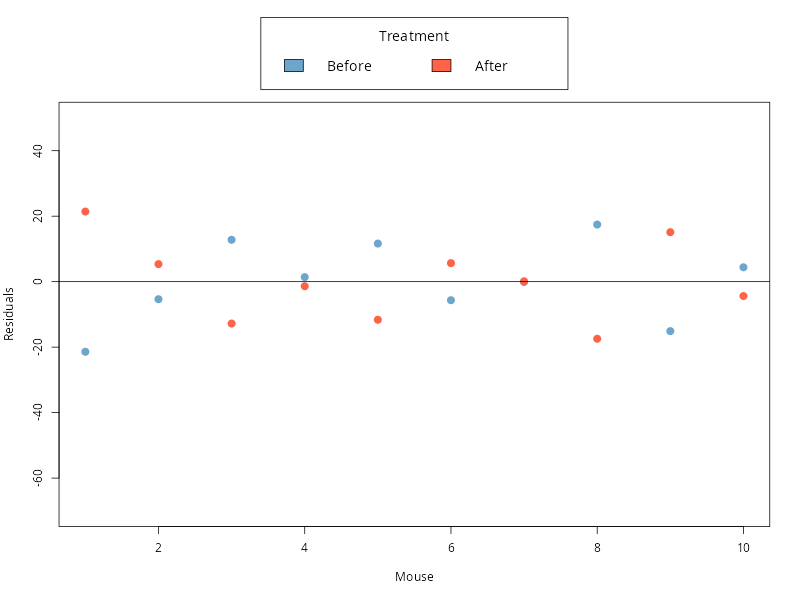

In [10]:
res.nosub <- resid(lm(weight ~ treatment + as.factor(id), data=mice2.long))

par(mar=c(5.1, 4.1, 7.1, 2.1), xpd=TRUE)

plot(mice2.long$id,
     res.nosub,
     col=c(rep('skyblue3',10),rep('tomato1',10)),
     xlab='Mouse',
     ylab='Residuals',
     pch=16,
     cex=1.5,
     ylim=c(-70,50))

abline(h=0, xpd=FALSE)

legend("top", 
       inset=c(0,-.2), 
       title="Treatment",
       c("Before","After"), 
       fill=c('skyblue3','tomato1'), 
       horiz=TRUE, 
       cex=1.2)

Now we can see that the constant offset that moves each subject in different directions from the grand mean has been removed. Each subject is now *on an equal footing*. Mouse 6 is no longer far above the grand mean, nor is Mouse 8 far below the grand mean. Going back to our model, this shows

$$
y_{ij} - \mu_{j} - S_{i} = \epsilon_{ij}.
$$

We have therefore removed the element that causes the data to be correlated. Subtracting the $S_{i}$ effectively removes the value that shifts each subject's measurements *away* from the mean by some amount that is *unique* to each subject, but *constant* across their own measurements. In the paired $t$-test, this removal is *implicit* in the subtraction of the pairs and the only error that remains is $\epsilon_{ij}$. However, we do also have the option of making this removal *explicit* by including the subject constants in the model itself. This method is known as a *partitioned errors* model and is the next step towards more general methods we will cover later in the lesson.

## The Model of *Partitioned Errors*

### Partitioning the Error

Notice that a huge amount of the variation in this data was attributable to the variation between different subjects. Now that this has been removed, we can effectively treat our data as *one big sample from a single subject*. As such, the variability we can see between all pairs of measurements provides us with an indication of how *internally consistent* a single subject is across the different conditions of the task. With the overall effect of the conditions removed, this remaining variability is not related to the conditions themseleves. Rather, it is related to other sources of random variation that cause an individual's response to change across multiple repeats of an experiment. This is known as the  *within-subject variance*. 

The variance associated with the two conditions is of direct interest because this captures our experimental effect of interest. Both the *between-subjects* and *within-subject* variance are effectively sources of *error* because they indicate different ways that the raw data may differ from the means of the conditions. One of these errors comes from the fact that different people may respond consistently higher or lower than the mean. The other comes from the fact that, even if an individual did not respond differently from the mean, natural variation across repeats will always be there.

This partitioning of variance can be formally stated as

$$
\text{Var}(y) = \sigma^{2} = \sigma^{2}_{b} + \sigma^{2}_{w}.
$$

As such, we now have *three* choices when it comes to calculating standard errors. Do we use the pooled variance of $\sigma^{2}$? The between-subjects variance of $\sigma^{2}_{b}$, or the within-subject variance of $\sigma^{2}_{w}$?

Key Point
In a regular paired t-test, the error variance consists of the differences between the means of the groups and the raw data. Howevever, when we have repeated measurements, this difference can be further divided into two sources ... This is consistent with the idea of the *between-subjects variance* $\left(\sigma^{2}_{b}\right)$ and the *within-subject variance* $\left(\sigma^{2}_{w}\right)$ ... As such, the difference with a *paired* test is that is uses the *within-subject variance* exclusively for determining the denominator of the $t$-statistic.

### Partitioning the Error as a Decomposition of the Variance-covariance Matrix
Now, we will connect what we have done above with the idea of modelling the variance-covariance matrix. Rather than doing this *explicitly*, the method above was an *implicit* modelling of the covariance structure...

### Where Does the Standard Error Come From?
To begin understanding what is going on here, we need to review where the value for the standard error comes from. In the context of a linear model, the standard error of $\hat{\beta}_{1}$ is given by

$$
\text{SE}\left(\hat{\beta}_{1}\right) = \sqrt{\text{Var}\left(\hat{\beta}_{1}\right)} = \sqrt{\frac{\hat{\sigma}^{2}}{\sum_{i=1}^{n}\left(x_{i1} - \bar{x}_{1}\right)}}.
$$

So, the standard error is the square-root of the variance of an estimate, and the variance of an estimate is simply a scaled version of the error variance from the model. This scaling is not entirely clear when represented in the format above. However, when $x_{1}$ is simply a dummy variable encoding a mean difference, this simplifies to the known formula for the denominator of a $t$-test assuming equal variance in the two samples

$$
\text{SE}\left(\hat{\beta}_{1}\right) = \text{SE}\left(\hat{\mu}_{1} - \hat{\mu}_{2}\right) = \sqrt{\frac{\hat{\sigma}^{2}}{\frac{1}{\frac{1}{n_{1}} + \frac{1}{n_{2}}}}} = \sqrt{\hat{\sigma}^{2}\left(\frac{1}{n_{1}} + \frac{1}{n_{2}}\right)}.
$$

Here, we can more easily see that the standard error depends only upon the sample sizes and the error variance.

`````{admonition} Key Point!
:class: tip
Under multiple repeats of the same experimnent, the sample sizes of the groups will remain the same. As such, this element of the standard error is simply a *constant scaling*. Whether the data are independent or not will not change this element of the standard error because the formula is *always the same*. The only element that can change is the *error variance*. As such, this must be the source of the difference between the *two-sample* and *paired* approaches.
`````

We can verify that this formula for the standard error is correct in the *two-sample* model by calculating

In [11]:
sigma2 <- summary(two.sample.mod)$sigma^2
sqrt(sigma2 * (1/50 + 1/50))

: [1m[33mError[39m:[22m
[33m![39m object 'two.sample.mod' not found

which agrees with out results so far. As the element of most interest here is the estimate of $\sigma^{2}$, the next obvious question is where does this come from? 

As a review, the error variance in a linear model is estimated using

$$
\hat{\sigma}^{2} = \frac{\sum_{i=1}^{n}\epsilon_{i}^{2}}{n-p},
$$

which is also known as the *residual mean square* or *error mean square*. We can again verify this for our example by calculating

In [ ]:
sigma2

sum(resid(two.sample.mod)^2) / two.sample.mod$df.residual



As such, if this is the element that differs between the *two-sample* and *paired* model, then our final suspect must be the *model residuals*. More specifically, the residuals must be *larger* in the *two-sample* case and *smaller* in the *paired* case. This is the only way the standard errors can differ. But this still does not explain *why* this is the case?

### Recreating the Paired $t$-test in the Linear Model

From all we discussed earlier, the aim is therefore to *remove* the between-subject variance from the residuals so that the error variance of the model only contains the *within-subject variance*. If we do not do this, then $\sigma^{2} = \sigma^{2}_{b} + \sigma^{2}_{w}$, which will be too large to accurately capture the standard error of the mean difference under repeated measurements.

In [ ]:
library(car)

subject <- rep(seq(1,50),each=2)
subject <- as.factor(subject)

paired.mod <- lm(y.long ~ cond + subject)
summary(paired.mod)

print(Anova(paired.mod))

Now, the output here is a bit of mess due to all the subject effects. However, if you look at the coefficient and test for `CondB`, notice that $t = 2.495$ and $p = 0.016$, which is the same as the *paired* $t$-test from earlier. Furthermore, the degrees of freedom are now correct at $49$. As such, adding the subject effects to the model has allowed the *between-subjects* error to be partitioned out and thus the remaining variance calculated from the residuals is *only* the *within-subject* error. This is the error needed to correctly estimate the standard error of the paired difference and thus the model results are now correct.

[^foot2]: Here we set the variance to be the same between the samples because this (a) agrees with the simulations and (b) prevents conflation of the issue of correlation with conflation of the issue of homogeneity of variance.

[^foot1]: Due to the way the factors are coded in `R`, the coefficient is actually the opposite comparison here, hence why the $t$-statistic is *positive* rather than *negative*.